In [1]:
from sklearn.datasets import make_blobs
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#1.构建数据
data, label = make_blobs(centers=3, n_features=10, cluster_std=1.2, n_samples=500, random_state=1)


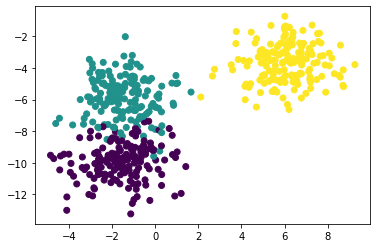

In [2]:
plt.scatter(data[:, 0], data[:, 2], c=label)
plt.show()

In [3]:
#2.自定义k-means、谱聚类
def euclidean_distance(one_sample,x):
    one_sample=one_sample.reshape(1,-1)
    distances=np.power(np.tile(one_sample,(x.shape[0],1))-x,2).sum(axis=1)
    return distances

In [4]:
class kmeans():
    """
    Kmeans聚类

    """
    def __init__(self,k=2,max_iterations=500, varepsilon=0.0001):
        """
        k:int 聚类数目
        max_iterations:int  最大迭代数目
        varepsilon:float 判断是否收敛，如果上一次的所有k个聚类中心与本次所有k个聚类中心都小于这个值，那么说明已经收敛
        """
        self.k=k
        self.max_iterations=max_iterations
        self.varepsilon=varepsilon
        np.random.seed(1)
    def init_random_centroids(self,x):
        #从所有样本中随机选取样本作为初始的聚类中心
        """
        输入x 即所需聚类的样本
        随机进行初始化，返回初始化聚类中心
        """
        n_samples,n_features=np.shape(x)
        centroids=np.zeros((self.k,n_features))
        for i in range(self.k):
            centroid=x[np.random.choice(range(n_samples))]
            centroids[i]=centroid
        return centroids
    def _closet_centroid(self,sample,centoids):
        #返回距离该样本最近的中心索引
        """
        输入样本 sample,centoids中心坐标
        返回最近的中心的索引
        
        """
        distances=euclidean_distance(sample,centoids)
        closest_i=np.argmin(distances)

        return closest_i
    def create_clusters(self,centroids,x):
        """
        输入 x 样本
        centroids 中心坐标
        输出 聚类结果
        """
        clusters=[ [] for _ in range(self.k)]
        for sample_i,sample in enumerate(x):
            centroid_i=self._closet_centroid(sample,centroids)
            clusters[centroid_i].append(sample_i)
        return clusters
    def update_centroids(self,clusters,x):
        """
        更新中心点
        输入 clusters 聚类结果
        x 样本
        返回 新的中心点坐标
        """
        n_features=np.shape(x)[1]
        centroids=np.zeros((self.k,n_features))
        for i ,cluster in enumerate(clusters):
            centroid=np.mean(x[cluster],axis=0)
            centroids[i]=centroid
        return centroids
    def get_cluster_labels(self,clusters,x):
        """
        输入 x 样本
        centroids 中心坐标
        输出 聚类结果标签
        """
        y_pred=np.zeros(np.shape(x)[0])
        for cluster_i,cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i]=cluster_i
        return y_pred

    def predict(self,x):
        """
        预测x对应的label
        """
        centroids=self.init_random_centroids(x)

        for _ in range(self.max_iterations):
            clusters=self.create_clusters(centroids,x)
            former_centroids=centroids
            centroids=self.update_centroids(clusters,x)
            diff=centroids-former_centroids
            if diff.any() <self.varepsilon:
                break
        return self.get_cluster_labels(clusters,x)


In [5]:
"""
谱聚类算法
核心思想：构建样本点的图，切分图，使得子图内权重最大，子图间权重最小
"""
import numpy as np

class Spectrum:
    def __init__(self, n_cluster, epsilon=1e-3, maxstep=1000, method='unnormalized',
                 criterion='gaussian', gamma=2.0, dis_epsilon=70, k=5):
        self.n_cluster = n_cluster
        self.epsilon = epsilon
        self.maxstep = maxstep
        self.method = method  # 本程序提供规范化以及非规范化的谱聚类算法
        self.criterion = criterion  # 相似性矩阵的构建方法
        self.gamma = gamma  # 高斯方法中的sigma参数
        self.dis_epsilon = dis_epsilon  # epsilon-近邻方法的参数
        self.k = k  # k近邻方法的参数
        self.kmens=kmeans(k=n_cluster,max_iterations=maxstep, varepsilon=epsilon)

        self.W = None  # 图的相似性矩阵
        self.L = None  # 图的拉普拉斯矩阵
        self.L_norm = None  # 规范化后的拉普拉斯矩阵
        self.D = None  # 图的度矩阵
        self.cluster = None

        self.N = None

    def init_param(self, data):
        # 初始化参数
        self.N = data.shape[0]
        dis_mat = self.cal_dis_mat(data)
        self.cal_weight_mat(dis_mat)
        self.D = np.diag(self.W.sum(axis=1))
        self.L = self.D - self.W
        return

    def cal_dis_mat(self, data):
        # 计算距离平方的矩阵
        dis_mat = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                dis_mat[i, j] = (data[i] - data[j]) @ (data[i] - data[j])
                dis_mat[j, i] = dis_mat[i, j]
        return dis_mat

    def cal_weight_mat(self, dis_mat):
        # 计算相似性矩阵
        if self.criterion == 'gaussian':  # 适合于较小样本集
            if self.gamma is None:
                raise ValueError('gamma is not set')
            self.W = np.exp(-self.gamma * dis_mat)
        elif self.criterion == 'k_nearest':  # 适合于较大样本集
            if self.k is None or self.gamma is None:
                raise ValueError('k or gamma is not set')
            self.W = np.zeros((self.N, self.N))
            for i in range(self.N):
                inds = np.argpartition(dis_mat[i], self.k + 1)[:self.k + 1]  # 由于包括自身，所以+1
                tmp_w = np.exp(-self.gamma * dis_mat[i][inds])
                self.W[i][inds] = tmp_w
        elif self.criterion == 'eps_nearest':  # 适合于较大样本集
            if self.dis_epsilon is None:
                raise ValueError('epsilon is not set')
            self.W = np.zeros((self.N, self.N))
            for i in range(self.N):
                inds = np.where(dis_mat[i] < self.dis_epsilon)
                self.W[i][inds] = 1.0 / len(inds)
        else:
            raise ValueError('the criterion is not supported')
        return

    def predict(self, data):
        # 训练主函数
        self.init_param(data)
        if self.method == 'unnormalized':
            w, v = np.linalg.eig(self.L)
            inds = np.argsort(w)[:self.n_cluster]
            Vectors = v[:, inds]
        elif self.method == 'normalized':
            D = np.linalg.inv(np.sqrt(self.D))
            L = D @ self.L @ D
            w, v = np.linalg.eig(L)
            inds = np.argsort(w)[:self.n_cluster]
            Vectors = v[:, inds]
            normalizer = np.linalg.norm(Vectors, axis=1)
            normalizer = np.repeat(np.transpose([normalizer]), self.n_cluster, axis=1)
            Vectors = Vectors / normalizer
        else:
            raise ValueError('the method is not supported')
    
        self.cluster = self.kmens.predict(Vectors) 
        return

In [6]:
#3.1自定义的谱聚类实验

In [7]:
sp = Spectrum(n_cluster=3, method='unnormalized', criterion='gaussian', gamma=0.1)
sp.predict(data)
cluster = sp.cluster
print(cluster)
sp_cluster=cluster

[1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 2. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.

In [8]:
label[label==0]=-1
label[label==1]=-2
label[label==2]=-3
label

array([-2, -3, -2, -1, -3, -1, -3, -3, -2, -2, -2, -1, -3, -3, -3, -1, -2,
       -2, -2, -3, -1, -3, -1, -1, -3, -3, -2, -2, -3, -1, -3, -1, -3, -2,
       -1, -1, -2, -3, -2, -3, -1, -2, -3, -1, -2, -1, -1, -2, -3, -2, -2,
       -1, -2, -2, -2, -3, -3, -3, -1, -2, -1, -1, -3, -3, -3, -1, -1, -3,
       -3, -3, -2, -2, -3, -1, -2, -3, -1, -3, -2, -1, -2, -2, -1, -2, -1,
       -1, -2, -2, -2, -3, -1, -2, -2, -1, -1, -2, -2, -3, -2, -1, -2, -1,
       -1, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -1, -1, -2, -3, -2,
       -1, -3, -2, -2, -1, -2, -1, -2, -3, -1, -2, -3, -3, -3, -1, -2, -3,
       -2, -3, -2, -1, -3, -3, -1, -3, -2, -2, -1, -1, -2, -2, -1, -3, -2,
       -3, -1, -2, -3, -1, -1, -3, -3, -1, -1, -2, -2, -3, -2, -2, -2, -3,
       -2, -3, -1, -1, -3, -1, -1, -2, -3, -2, -3, -3, -2, -1, -1, -3, -1,
       -1, -2, -2, -2, -1, -2, -3, -2, -2, -2, -2, -3, -3, -1, -3, -1, -1,
       -1, -3, -3, -1, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -2, -3, -3

In [9]:
#对数据集聚类 计算吻合度
acc=accuracy_score(label,cluster)
print('吻合度{:.2f}'.format(acc))

吻合度0.00


In [10]:
label[label==0]=-1
label[label==1]=-2
label[label==2]=-3
label

array([-2, -3, -2, -1, -3, -1, -3, -3, -2, -2, -2, -1, -3, -3, -3, -1, -2,
       -2, -2, -3, -1, -3, -1, -1, -3, -3, -2, -2, -3, -1, -3, -1, -3, -2,
       -1, -1, -2, -3, -2, -3, -1, -2, -3, -1, -2, -1, -1, -2, -3, -2, -2,
       -1, -2, -2, -2, -3, -3, -3, -1, -2, -1, -1, -3, -3, -3, -1, -1, -3,
       -3, -3, -2, -2, -3, -1, -2, -3, -1, -3, -2, -1, -2, -2, -1, -2, -1,
       -1, -2, -2, -2, -3, -1, -2, -2, -1, -1, -2, -2, -3, -2, -1, -2, -1,
       -1, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -1, -1, -2, -3, -2,
       -1, -3, -2, -2, -1, -2, -1, -2, -3, -1, -2, -3, -3, -3, -1, -2, -3,
       -2, -3, -2, -1, -3, -3, -1, -3, -2, -2, -1, -1, -2, -2, -1, -3, -2,
       -3, -1, -2, -3, -1, -1, -3, -3, -1, -1, -2, -2, -3, -2, -2, -2, -3,
       -2, -3, -1, -1, -3, -1, -1, -2, -3, -2, -3, -3, -2, -1, -1, -3, -1,
       -1, -2, -2, -2, -1, -2, -3, -2, -2, -2, -2, -3, -3, -1, -3, -1, -1,
       -1, -3, -3, -1, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -2, -3, -3

In [11]:
cluster = sp.cluster
cluster[cluster==2]=-1
cluster[cluster==0]=-3
cluster[cluster==1]=-2
cluster

array([-2., -3., -2., -2., -3., -2., -3., -3., -2., -2., -2., -2., -3.,
       -3., -3., -2., -2., -2., -2., -3., -2., -3., -2., -2., -3., -1.,
       -2., -2., -3., -2., -3., -2., -3., -2., -2., -2., -2., -3., -2.,
       -3., -2., -2., -3., -2., -2., -2., -2., -2., -3., -2., -2., -2.,
       -2., -2., -2., -3., -3., -3., -2., -2., -2., -2., -3., -3., -3.,
       -2., -2., -3., -3., -3., -2., -2., -3., -2., -2., -3., -2., -3.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -3., -2.,
       -2., -2., -2., -2., -2., -2., -3., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -3., -2., -2., -3., -2., -2., -2., -2., -2., -2., -3., -2., -2.,
       -3., -3., -3., -2., -2., -3., -2., -3., -2., -2., -3., -3., -2.,
       -3., -2., -2., -2., -2., -2., -2., -2., -3., -2., -3., -2., -2.,
       -3., -2., -2., -3., -3., -2., -2., -2., -2., -3., -2., -2., -2.,
       -3., -2., -3., -2., -2., -3., -2., -2., -2., -3., -2., -3

In [12]:

acc=accuracy_score(label,cluster)
print('吻合度{:.2f}'.format(acc))

吻合度0.66


In [13]:
#3.2 kmeans聚类实验
kmeans_cluster=kmeans(3,1000,0.001)
clusters=kmeans_cluster.predict(data)

In [14]:
clusters

array([1., 0., 1., 1., 2., 1., 0., 0., 1., 1., 1., 1., 0., 0., 2., 1., 1.,
       1., 1., 2., 1., 0., 1., 1., 2., 0., 1., 1., 2., 1., 2., 1., 0., 1.,
       1., 1., 1., 2., 1., 0., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 2., 0., 2., 1., 1., 1., 1., 2., 0., 2., 1., 1., 2.,
       2., 2., 1., 1., 2., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 2., 2., 1., 1., 2.,
       1., 0., 1., 1., 2., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 2., 2., 1., 1., 1., 1., 2., 1., 1., 1., 2.,
       1., 2., 1., 1., 2., 1., 1., 1., 2., 1., 2., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 0., 2., 1., 0., 1., 1.,
       1., 0., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 2., 0.

In [15]:
clusters[clusters==0]=-1
clusters[clusters==1]=-2
clusters[clusters==2]=-3

In [16]:
#对数据集聚类 计算吻合度
acc=accuracy_score(label,clusters)
print('吻合度{:.2f}'.format(acc))

吻合度0.53


In [17]:
#3.3 sklearn聚类实验
from sklearn.cluster import SpectralClustering
y_pred = SpectralClustering().fit_predict(data)
y_pred

array([0, 2, 0, 4, 2, 4, 2, 2, 0, 0, 0, 4, 2, 2, 2, 4, 0, 0, 0, 2, 4, 2,
       4, 4, 2, 2, 0, 0, 2, 4, 3, 4, 2, 0, 4, 4, 0, 2, 0, 2, 4, 0, 2, 4,
       0, 4, 4, 0, 2, 0, 0, 4, 0, 0, 0, 2, 7, 2, 4, 0, 4, 4, 2, 2, 2, 4,
       4, 2, 2, 2, 0, 0, 2, 4, 6, 2, 4, 2, 0, 4, 0, 0, 4, 0, 4, 4, 6, 6,
       0, 2, 4, 0, 1, 4, 4, 0, 5, 2, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 0, 4, 4, 0, 2, 0, 4, 2, 0, 0, 4, 0, 4, 0, 2, 4, 0, 2, 2,
       2, 4, 0, 2, 0, 2, 0, 4, 2, 2, 4, 2, 0, 0, 4, 4, 0, 0, 4, 2, 0, 2,
       4, 0, 2, 4, 4, 2, 2, 4, 4, 0, 0, 2, 0, 1, 0, 2, 0, 2, 4, 4, 2, 4,
       4, 0, 2, 0, 2, 2, 0, 4, 4, 2, 4, 4, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0,
       2, 2, 4, 2, 4, 4, 4, 2, 2, 4, 4, 2, 0, 0, 0, 4, 0, 4, 4, 4, 4, 4,
       4, 0, 4, 0, 2, 2, 2, 3, 3, 4, 7, 2, 2, 4, 4, 0, 2, 4, 2, 0, 2, 0,
       4, 4, 4, 4, 0, 2, 4, 0, 4, 2, 0, 2, 4, 4, 4, 0, 4, 4, 0, 0, 2, 2,
       2, 0, 0, 4, 4, 0, 2, 4, 2, 4, 4, 0, 2, 0, 2, 2, 0, 0, 2, 4, 4, 2,
       2, 2, 2, 0, 2, 4, 4, 0, 4, 2, 2, 0, 0, 2, 0,

In [18]:
y_pred[y_pred==2]=-3
y_pred[y_pred==4]=-1
y_pred[y_pred==0]=-2

In [19]:
acc=accuracy_score(label,y_pred)
print('吻合度{:.2f}'.format(acc))

吻合度0.96


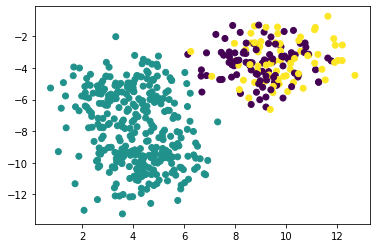

In [20]:
plt.scatter(data[:, 1], data[:, 2], c=clusters)
plt.show()

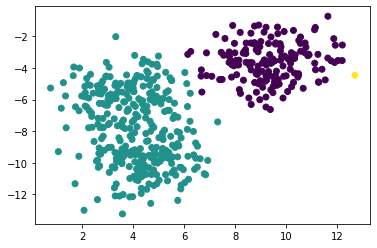

In [21]:
plt.scatter(data[:, 1], data[:, 2], c=sp_cluster)
plt.show()

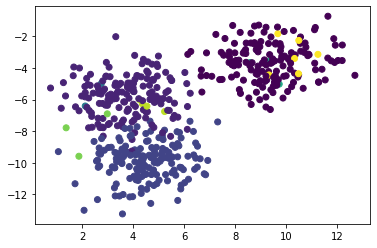

In [22]:
plt.scatter(data[:, 1], data[:, 2], c=y_pred)
plt.show()

In [34]:
y_pred = SpectralClustering(n_clusters=3, gamma=0.1).fit_predict(data)
y_pred

array([1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0,
       2, 2, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 2, 1, 0, 2,
       1, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1,
       1, 0, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0,
       0, 2, 1, 0, 1, 0, 1, 2, 0, 0, 2, 0, 1, 1, 2, 2, 1, 1, 2, 0, 1, 0,
       2, 1, 0, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0, 2,
       2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1,
       2, 2, 2, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 1, 0, 0,
       0, 1, 1, 2, 2, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0,
       0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 1,

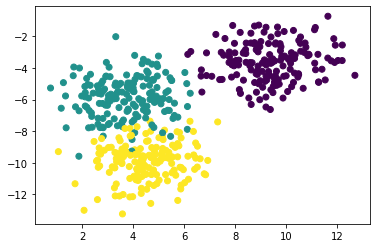

In [35]:
plt.scatter(data[:, 1], data[:, 2], c=y_pred)
plt.show()

In [36]:
y_pred[y_pred==2]=-1
y_pred[y_pred==1]=-2
y_pred[y_pred==0]=-3

In [37]:
y_pred

array([-2, -3, -2, -1, -3, -1, -3, -3, -2, -2, -2, -1, -3, -3, -3, -1, -2,
       -2, -2, -3, -1, -3, -1, -1, -3, -3, -2, -2, -3, -1, -3, -1, -3, -2,
       -1, -1, -2, -3, -2, -3, -1, -2, -3, -1, -2, -1, -1, -2, -3, -2, -2,
       -1, -2, -2, -2, -3, -3, -3, -1, -2, -1, -1, -3, -3, -3, -1, -1, -3,
       -3, -3, -2, -2, -3, -1, -2, -3, -1, -3, -2, -1, -2, -2, -1, -2, -1,
       -1, -2, -2, -2, -3, -1, -2, -2, -1, -1, -2, -2, -3, -2, -1, -2, -1,
       -1, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -1, -1, -2, -3, -2,
       -1, -3, -2, -2, -1, -2, -1, -2, -3, -1, -2, -3, -3, -3, -1, -2, -3,
       -2, -3, -2, -1, -3, -3, -1, -3, -2, -2, -1, -1, -2, -2, -1, -3, -2,
       -3, -1, -2, -3, -1, -1, -3, -3, -1, -1, -2, -2, -3, -2, -2, -2, -3,
       -2, -3, -1, -1, -3, -1, -1, -2, -3, -2, -3, -3, -2, -1, -1, -3, -1,
       -1, -2, -2, -2, -1, -2, -3, -2, -2, -2, -2, -3, -3, -1, -3, -1, -1,
       -1, -3, -3, -1, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -2, -3, -3

In [38]:
label

array([-2, -3, -2, -1, -3, -1, -3, -3, -2, -2, -2, -1, -3, -3, -3, -1, -2,
       -2, -2, -3, -1, -3, -1, -1, -3, -3, -2, -2, -3, -1, -3, -1, -3, -2,
       -1, -1, -2, -3, -2, -3, -1, -2, -3, -1, -2, -1, -1, -2, -3, -2, -2,
       -1, -2, -2, -2, -3, -3, -3, -1, -2, -1, -1, -3, -3, -3, -1, -1, -3,
       -3, -3, -2, -2, -3, -1, -2, -3, -1, -3, -2, -1, -2, -2, -1, -2, -1,
       -1, -2, -2, -2, -3, -1, -2, -2, -1, -1, -2, -2, -3, -2, -1, -2, -1,
       -1, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -1, -1, -2, -3, -2,
       -1, -3, -2, -2, -1, -2, -1, -2, -3, -1, -2, -3, -3, -3, -1, -2, -3,
       -2, -3, -2, -1, -3, -3, -1, -3, -2, -2, -1, -1, -2, -2, -1, -3, -2,
       -3, -1, -2, -3, -1, -1, -3, -3, -1, -1, -2, -2, -3, -2, -2, -2, -3,
       -2, -3, -1, -1, -3, -1, -1, -2, -3, -2, -3, -3, -2, -1, -1, -3, -1,
       -1, -2, -2, -2, -1, -2, -3, -2, -2, -2, -2, -3, -3, -1, -3, -1, -1,
       -1, -3, -3, -1, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -2, -3, -3

In [28]:
label[label==0]=-3
label[label==1]=-1
label[label==2]=-2

In [29]:
label

array([-2, -3, -2, -1, -3, -1, -3, -3, -2, -2, -2, -1, -3, -3, -3, -1, -2,
       -2, -2, -3, -1, -3, -1, -1, -3, -3, -2, -2, -3, -1, -3, -1, -3, -2,
       -1, -1, -2, -3, -2, -3, -1, -2, -3, -1, -2, -1, -1, -2, -3, -2, -2,
       -1, -2, -2, -2, -3, -3, -3, -1, -2, -1, -1, -3, -3, -3, -1, -1, -3,
       -3, -3, -2, -2, -3, -1, -2, -3, -1, -3, -2, -1, -2, -2, -1, -2, -1,
       -1, -2, -2, -2, -3, -1, -2, -2, -1, -1, -2, -2, -3, -2, -1, -2, -1,
       -1, -2, -1, -1, -1, -1, -1, -1, -1, -2, -2, -2, -1, -1, -2, -3, -2,
       -1, -3, -2, -2, -1, -2, -1, -2, -3, -1, -2, -3, -3, -3, -1, -2, -3,
       -2, -3, -2, -1, -3, -3, -1, -3, -2, -2, -1, -1, -2, -2, -1, -3, -2,
       -3, -1, -2, -3, -1, -1, -3, -3, -1, -1, -2, -2, -3, -2, -2, -2, -3,
       -2, -3, -1, -1, -3, -1, -1, -2, -3, -2, -3, -3, -2, -1, -1, -3, -1,
       -1, -2, -2, -2, -1, -2, -3, -2, -2, -2, -2, -3, -3, -1, -3, -1, -1,
       -1, -3, -3, -1, -1, -3, -2, -2, -2, -1, -2, -1, -1, -1, -1, -1, -1,
       -2, -1, -2, -3, -3

In [39]:
acc=accuracy_score(label,y_pred)
print('吻合度{:.2f}'.format(acc))

吻合度1.00
